# EECS 595 HW3: Parts 1-3 Building and Pre-Training BERT from Scratch

In [1]:
# !pip install wandb

In [2]:
import os
import math
import numpy as np
import random
import logging

# Bring in PyTorch
import torch
import torch.nn as nn

# Most of the examples have typing on the signatures for readability
from typing import Optional, Callable, List, Tuple
from copy import deepcopy
# For data loading
from torch.utils.data import Dataset, IterableDataset, TensorDataset, DataLoader
import json
import glob
import gzip
import bz2
# import wandb

import matplotlib.pyplot as plt

# For progress and timing
from tqdm.auto import tqdm, trange
import time

# wandb.login()

In [4]:
from tokenizers import BertWordPieceTokenizer

tokenizer = BertWordPieceTokenizer("vocab.txt", lowercase=True)

# Tokenize 5 sentences
sentences = [
    "BERT's attention mechanism allows it to capture contextual information effectively.",
    "Fine-tuning BERT on domain-specific data can yield impressive results.",
    "Understanding BERT's architecture is crucial for leveraging its capabilities.",
    "BERT embeddings are widely used in various downstream NLP tasks.",
    "BERT revolutionized the field of natural language understanding."
]

for sentence in sentences:
    encoded_sentence = tokenizer.encode(sentence)
    print(f"Sentence: {sentence}")
    print(f"Tokens: {encoded_sentence.tokens}")
    print()


Sentence: BERT's attention mechanism allows it to capture contextual information effectively.
Tokens: ['[CLS]', 'bert', "'", 's', 'attention', 'mechanism', 'allows', 'it', 'to', 'capture', 'context', '##ual', 'information', 'effectively', '.', '[SEP]']

Sentence: Fine-tuning BERT on domain-specific data can yield impressive results.
Tokens: ['[CLS]', 'fine', '-', 'tuning', 'bert', 'on', 'domain', '-', 'specific', 'data', 'can', 'yield', 'impressive', 'results', '.', '[SEP]']

Sentence: Understanding BERT's architecture is crucial for leveraging its capabilities.
Tokens: ['[CLS]', 'understanding', 'bert', "'", 's', 'architecture', 'is', 'crucial', 'for', 'lever', '##aging', 'its', 'capabilities', '.', '[SEP]']

Sentence: BERT embeddings are widely used in various downstream NLP tasks.
Tokens: ['[CLS]', 'bert', 'em', '##bed', '##ding', '##s', 'are', 'widely', 'used', 'in', 'various', 'downstream', 'nl', '##p', 'tasks', '.', '[SEP]']

Sentence: BERT revolutionized the field of natural lan

In [5]:
class BertPositionalEmbedding(nn.Module):
    def __init__(self, vocab_dim: int, 
                 hidden_dim: int = 768, 
                 padding_idx: int = 0, 
                 max_seq_length: int = 512):
        
        super().__init__()

        '''
        Initialize the Embedding Layers
        '''

        self.word_embeddings = nn.Embedding(vocab_dim, hidden_dim, padding_idx=padding_idx)
        self.pos_embeddings = nn.Embedding(max_seq_length, hidden_dim)

        self.padding_idx = padding_idx

    def forward(self, token_ids: torch.Tensor) -> torch.Tensor:
        
        '''
        Define the forward pass of the Embedding Layers
        '''
        
        token_embeddings = self.word_embeddings(token_ids)
        
        pos_ids = torch.arange(0, token_ids.size(-1), dtype=torch.long, device=token_ids.device)
        pos_embeddings = self.pos_embeddings(pos_ids)
        
        return token_embeddings + pos_embeddings

In [6]:
q_emb = torch.randn(10, 4, 7)
k_emb = torch.randn(10, 4, 7)
v_emb = torch.randn(10, 4, 7)

dot_prod = (q_emb @ k_emb.transpose(-1, -2)) 

attn = nn.functional.softmax(dot_prod, dim=-1)

print(attn.shape)

weighted_output = attn @ v_emb

print(weighted_output.shape)

torch.Size([10, 4, 4])
torch.Size([10, 4, 7])


In [7]:
q_emb = torch.randint(10, (3, 8))
print(q_emb)
q_s = q_emb.shape
print(q_s)
n_heads = 2
multihead_q_emb = q_emb.view(n_heads, q_s[0], q_s[1]//n_heads)

print(multihead_q_emb.shape)

print(multihead_q_emb)

tensor([[0, 5, 6, 0, 4, 7, 0, 1],
        [8, 5, 2, 0, 2, 6, 3, 5],
        [6, 3, 5, 6, 4, 8, 0, 6]])
torch.Size([3, 8])
torch.Size([2, 3, 4])
tensor([[[0, 5, 6, 0],
         [4, 7, 0, 1],
         [8, 5, 2, 0]],

        [[2, 6, 3, 5],
         [6, 3, 5, 6],
         [4, 8, 0, 6]]])


In [8]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, hidden_size: int, num_heads: int):
        '''
        Arguments:
        hidden_size: The total size of the hidden layer (across all heads)
        num_heads: The number of attention heads to use
        '''
        super().__init__()

        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads

        '''
        Initialize the Multi-Headed Attention Layer
        '''

        self.query_proj = nn.Linear(hidden_size, hidden_size)
        self.key_proj = nn.Linear(hidden_size, hidden_size)
        self.value_proj = nn.Linear(hidden_size, hidden_size)

        self.output_proj = nn.Linear(hidden_size, hidden_size)

    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: Optional[torch.Tensor] = None):
        '''
        Arguments:
        query: The input embeddings for the query
        key: The input embeddings for the key
        value: The input embeddings for the value
        mask: A boolean mask of which tokens are valid to use for computing attention (see collate below)
        '''
        batch_size = query.shape[0]

        queries = query.view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        keys = key.view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)
        values = value.view(batch_size, -1, self.num_heads, self.head_size).transpose(1, 2)

        attention_scores = torch.matmul(queries, keys.transpose(-2, -1)) / math.sqrt(self.head_size)

        attention_weights = torch.softmax(attention_scores, dim=-1)
        weighted_values = torch.matmul(attention_weights, values)

        weighted_values = weighted_values.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.head_size)
        output = self.output_proj(weighted_values)

        return output, attention_weights

In [9]:
def feed_forward_layer(
    hidden_size: int,
    feed_forward_size: Optional[int] = None,
    activation: nn.Module = nn.GELU()
):
    '''
    Arguments:
      - hidden_size: The size of the input and output of the feed forward layer.
      - feed_forward_size: The size of the hidden layer in the feed forward network. If None, defaults to 4 * hidden_size. This size
        specifies the size of the middle layer in the feed forward network.
      - activation: The activation function to use in the feed forward network

    Returns:
        A PyTorch module representing the feed forward layer.
    '''

    if feed_forward_size is None:
        feed_forward_size = hidden_size * 4

    feed_forward = nn.Sequential(
        nn.Linear(hidden_size, feed_forward_size),
        activation,
        nn.Linear(feed_forward_size, hidden_size)
    )

    return feed_forward

In [10]:
class TransformerEncoderLayer(nn.Module):

    def __init__(
        self,
        hidden_size: int = 256,
        num_heads: int = 8,
        dropout: float = 0.1,
        activation: nn.Module = nn.ReLU(),
        feed_forward_size: Optional[int] = None,
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.feed_forward_size = feed_forward_size or 4 * hidden_size

        self.attention = MultiHeadedAttention(hidden_size, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(hidden_size, self.feed_forward_size),
            activation,
            nn.Linear(self.feed_forward_size, hidden_size)
        )

    def maybe_dropout(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(x)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        '''
        Returns the output of the transformer encoder layer and the attention weights from the self-attention layer
        '''
        attention_output, attention_weights = self.attention(x, x, x, mask)
        attention_output = self.maybe_dropout(attention_output)

        residual_output = attention_output + x  

        feed_forward_output = self.feed_forward(residual_output)
        feed_forward_output = self.maybe_dropout(feed_forward_output)

        output = feed_forward_output + residual_output  

        return output, attention_weights

In [11]:
class MLMHead(nn.Module):
    def __init__(self, word_embeddings: nn.Embedding):
        '''
        Arguments:
            word_embeddings: The word embeddings to use for the prediction
        '''

        super().__init__()
        self.word_embeddings = word_embeddings

    def forward(self, x):
        '''
        x: The input tensor to the MLM head containing a batch of sequences of
           contextualized word embeddings (activations from the transformer encoder 
           layers)
        '''
        return x @ self.word_embeddings.weight.transpose(0, 1)

In [12]:
class Pooler(nn.Module):
    def __init__(self, hidden_size: int = 768):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cls_embeddings = x[:, 0, :]  

        pooled_output = self.dense(cls_embeddings)
        pooled_output = self.activation(pooled_output)

        return pooled_output

In [13]:
class BERT(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        padding_idx: int = 0,
        hidden_size: int = 768,
        num_heads: int = 12,
        num_layers: int = 12,
        dropout: float = 0.1,
        activation: nn.Module = nn.GELU(),
        feed_forward_size: Optional[int] = None,
        mode: str = "mlm",
        num_classes: Optional[int] = None,
    ):
        '''
        Defines BERT model architecture. Note that the arguments are the same as the default
        BERT model in HuggingFace but we'll be training a *much* smaller model for this homework.

        Arguments:
        vocab_size: The size of the vocabulary (determined by the tokenizer)
        padding_idx: The index of the padding token in the vocabulary (defined by the tokenizer)
        hidden_size: The size of the hidden layer and embeddings in the transformer encoder
        num_heads: The number of attention heads to use in the transformer encoder
        num_layers: The number of layers to use in the transformer encoder (each layer is a TransformerEncoderLayer)
        dropout: The dropout rate to use in the transformer encoder (what % of times to randomly zero out activations)
        activation: The activation function to use in the transformer encoder
        feed_forward_size: The size of the hidden layer in the feed forward network in the transformer encoder. If None, defaults to 4 * hidden_size
        mode: The mode of the BERT model. Either "mlm" for masked language modeling or "classification" for sequence classification
        num_classes: The number of classes to use in the classification layer.
        '''

        super().__init__()

        self.mode = mode
        self.hidden_size = hidden_size

        self.embeddings = BertPositionalEmbedding(vocab_size, hidden_size, padding_idx)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(hidden_size, num_heads, dropout, activation, feed_forward_size)
            for _ in range(num_layers)
        ])
        self.mlm_head = MLMHead(self.embeddings.word_embeddings)
        self.pooler = Pooler(hidden_size)

        if mode == "classification":
            self.classifier = nn.Linear(hidden_size, num_classes)
        else:
            self.classifier = None

        self.apply(self.init_layer_weights)

    def forward(
        self,
        x: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        '''
        arguments:
        x: The input token ids
        mask: The attention mask to apply to the input (see the collate function below)
        '''
        embeddings = self.embeddings(x)

        attention_weights = []
        for layer in self.encoder_layers:
            embeddings, attention_weight = layer(embeddings, mask)
            attention_weights.append(attention_weight)

        if self.mode == "mlm":
            output = self.mlm_head(embeddings)
        else:
            pooled_output = self.pooler(embeddings)
            output = self.classifier(pooled_output)

        return output, attention_weights

    def init_layer_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

In [14]:
'''
We can verify that the model is working by running a quick test.
'''

sentence = "The quick brown fox jumps over the lazy dog."
tokens = tokenizer.encode(sentence)
# to tensor
token_ids = torch.tensor(tokens.ids)
bert = BERT(vocab_size=tokenizer.get_vocab_size(), 
            hidden_size=768, 
            num_heads=4, 
            num_layers=2,
        )

attention_mask = (token_ids != 0).float()

output, attn = bert(token_ids.unsqueeze(0), attention_mask.unsqueeze(0))

print(output.shape)

torch.Size([1, 12, 30522])


In [15]:
class MLMDataset(Dataset):
    def __init__(self, tokenizer, data: list[str], max_seq_length=128, mlm_probability=0.15):
        self.tokenizer = tokenizer
        self.data = data
        self.max_seq_length = max_seq_length
        self.mlm_probability = mlm_probability
        self.tokenized_data = None

    def __len__(self):
        return len(self.tokenized_data)

    def tokenize(self):
        '''
        Tokenizes the text in self.data, performing any preprocessing and storing the tokenized data in a new list.
        '''
        tokenized_data = []
        for text in self.data:
            encoded = self.tokenizer.encode(text)
            tokenized_data.append(encoded.ids[:self.max_seq_length])

        self.tokenized_data = tokenized_data
        del self.data  

    def __getitem__(self, idx):
        '''
        Returns the list of the token ids of an instance in the dataset and a list of the labels for MLM (one label per token).
        '''
        instance = self.tokenized_data[idx]
        input_ids = instance.copy()
        labels = [-100] * len(instance)  

        # Create the mask
        masked_indices = np.random.choice(len(instance), int(len(instance) * self.mlm_probability), replace=False)
        for i in masked_indices:
            token_id = instance[i]
            token = self.tokenizer.id_to_token(token_id)
            if token not in ['[CLS]', '[SEP]', '[PAD]']:
                input_ids[i] = self.tokenizer.token_to_id('[MASK]')
                labels[i] = token_id

        return input_ids, labels

In [16]:
'''
Verify that the dataset is working by running a quick test.
'''

data = [' '.join([chr(97 + i) for i in range(random.randint(10, 20))]) for _ in range(1000)]

dataset = MLMDataset(tokenizer, data)
dataset.tokenize()

# get the first item
input_ids, labels = dataset[0]
print('input_ids:', input_ids)
print('labels:', labels)

input_ids: [101, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 103, 1051, 1052, 102]
labels: [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1050, -100, -100, -100]


In [17]:
## tet with one sentence
data = ["The quick brown fox jumps over the lazy dog.",
        "The quick brown fox jumps over the lazy dog.",
        "The quick brown fox jumps over the lazy dog.",]
dataset = MLMDataset(tokenizer, data)
dataset.tokenize()
print(dataset[0])


([101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 103, 1012, 102], [-100, -100, -100, -100, -100, -100, -100, -100, -100, 3899, -100, -100])


In [19]:
review_data_path = 'reviews-word2vec.tiny.txt'
#review_data_path = './reviews-word2vec.med.txt' # <- for sanity checking / debugging
# review_data_path = './reviews-word2vec.large.txt.gz' # <- for CPU pre-training and validating
#review_data_path = './reviews-word2vec.larger.txt.gz' <- for GPU pre-training and validating (Part 3.5)


# NOTE: when you eventually deploy this code to Great Lakes, you'll need to use the larger dataset 
# (see the PDF for notes/details)

ofunc = gzip.open if review_data_path.endswith('gz') else open
with ofunc(review_data_path, 'rt') as f:
    reviews = f.readlines()
    reviews = [review.strip() for review in reviews]

dataset = MLMDataset(tokenizer, reviews)
dataset.tokenize()

# get the first item
print(dataset[0])

([101, 2023, 2001, 4149, 2004, 1037, 103, 1010, 2021, 1996, 2711, 2040, 2288, 103, 1010, 3866, 2009, 999, 1998, 2027, 2097, 2224, 2009, 103, 102], [-100, -100, -100, -100, -100, -100, 5592, -100, -100, -100, -100, -100, -100, 2009, -100, -100, -100, -100, -100, -100, -100, -100, -100, 2574, -100])


In [20]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch: List[Tuple[List[int], List[int]]]):
    input_ids, labels = zip(*batch)

    padded_input_ids = pad_sequence([torch.tensor(ids) for ids in input_ids], batch_first=True, padding_value=0)
    padded_labels = pad_sequence([torch.tensor(label) for label in labels], batch_first=True, padding_value=-100)

    attention_mask = (padded_input_ids != 0).float() 

    return padded_input_ids, attention_mask, padded_labels

In [21]:
batch_size = 8
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

for input_ids, attention_mask, labels in dataloader:
    print(input_ids.shape)
    print(attention_mask.shape)
    print(labels.shape)
    break

torch.Size([8, 119])
torch.Size([8, 119])
torch.Size([8, 119])


In [20]:
# import wandb
# wandb.init(project="bert-mlm-training")

wandb: Currently logged in as: mohammadanas702. Use `wandb login --relogin` to force relogin


Using 1 GPU
Device: 'cuda'


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Step:   0%|          | 0/63 [00:00<?, ?it/s]

Step:   0%|          | 0/63 [00:00<?, ?it/s]

Step:   0%|          | 0/63 [00:00<?, ?it/s]

Model saved to 'bert_model.pt'


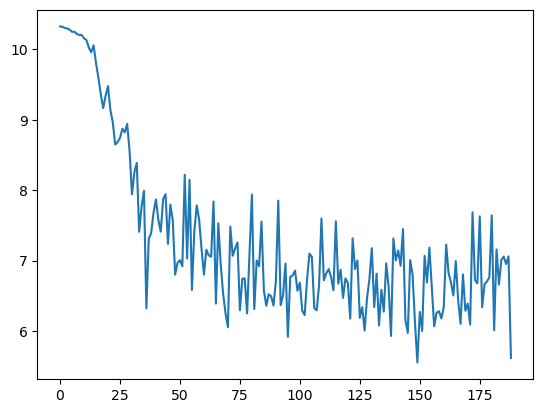

In [24]:
'''
Now, lets put it all together in the training loop.
'''

device = 'cpu'
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'

    num_gpus = torch.cuda.device_count()
    if num_gpus > 1:
        device_ids = [0, 1]  
        print(f"Using {len(device_ids)} GPUs: {', '.join(map(str, device_ids))}")
    else:
        device_ids = None  
        print("Using 1 GPU")

print(f"Device: '{device}'")

bert_model = BERT(vocab_size=tokenizer.get_vocab_size(),
                  hidden_size=768,
                  num_heads=12,
                  num_layers=6,
                  mode="mlm").to(device)

if device_ids is not None:
    bert_model = nn.DataParallel(bert_model, device_ids=device_ids)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 4e-5
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=learning_rate)

batch_size = 32
num_epochs = 3

losses = []

for epoch in trange(num_epochs, desc="Epoch"):
    for step, (input_ids, attention_mask, labels) in enumerate(tqdm(dataloader, position=1, leave=True, desc="Step")):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output, _ = bert_model(input_ids, mask=attention_mask)

        loss = loss_fn(output.view(-1, output.size(-1)), labels.view(-1))
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        # wandb.log({"loss": loss.item()})

    if device_ids is not None:

        torch.save(bert_model.module.state_dict(), f"bert_epoch_{epoch}.pt")
    else:

        torch.save(bert_model.state_dict(), f"bert_epoch_{epoch}.pt")

plt.plot(losses)

model_path = "bert_model.pt"

if device_ids is not None:

    torch.save(bert_model.module, model_path)
else:

    torch.save(bert_model, model_path)

print(f"Model saved to '{model_path}'")

In [33]:
'''
Now that we have trained the model, we can use it to predict the masked tokens.
'''

def noise_inputs(inputs, mask_token_id, mlm_probability=0.15):
    inputs = deepcopy(inputs)
    labels = [-100] * len(inputs)
    masked_indices = np.random.choice(len(inputs), int(len(inputs) * mlm_probability), replace=False)
    for i in masked_indices:
        if inputs[i] not in [mask_token_id, 101, 102, 0]:
            inputs[i] = mask_token_id
            labels[i] = inputs[i]
    return inputs, labels

def noise_and_predict_tokens(query, tokenizer, model) -> str:
    with torch.no_grad():
        tokenized_input = tokenizer.encode(query)
        tokens = tokenized_input.tokens
        print('Original:', ' '.join(tokens))
        ids = np.array(tokenized_input.ids)
        inputs, labels = noise_inputs(ids, tokenizer.token_to_id('[MASK]'))
        
        inputs = torch.tensor(inputs).to(next(model.parameters()).device)
        
        print('Noised: ', ' '.join([tokenizer.id_to_token(at_i) for at_i in inputs]))
        
        response, attns = model(inputs.unsqueeze(0))
        response = response.argmax(-1).squeeze(0).tolist()
        print('Guess:  ', ' '.join([tokenizer.id_to_token(at_i) for at_i in response[1:-1]]).replace(' ##', ''))

s = 'I really like the book it was great and I loved reading it.'
noise_and_predict_tokens(s, tokenizer, bert)


Original: [CLS] i really like the book it was great and i loved reading it . [SEP]
Noised:  [CLS] i really like the book [MASK] was [MASK] and i loved reading it . [SEP]
Guess:   i really like the book [MASK] was [MASK] and i loved reading it .


# Part 3.4: Save the Pre-Trained Model

At this point, save the model's parameters in its `state_dict`. See pytorch's [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for some guidance here. We'll be using this pre-trained model in later notebooks so once you save it, test that you can load it in another notebook (try `BERT_Inference.ipynb` to start) before moving on. 

In [ ]:
model_path = "bert_pretrained.pt"

torch.save(bert, model_path)

print(f"Model saved to '{model_path}'")

In [ ]:
bert_model = torch.load(model_path)